In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Analyses
from src.analyses.schedule_jobs_dataframe import jobs_metrics_from_operations_df, mean_start_deviation_per_shift_df

# Plots
from src.analyses.fig_experiment import make_combined_figure_startdeviation_tardiness_earliness

## Import and Merge

### I. Experiment Parameters

In [27]:
df_experiments = pd.read_csv("experiments_v01.csv")
df_experiments

,Experiment_ID,Abs Lateness Ratio,Inner Tardiness Ratio,Max Bottleneck Utilization,Sim Sigma,Shift Length,w_t,w_e,w_dev,Experiment_Type,max_utilization
0,B-1,0.25,1.00,0.75,0.1,1440,1,0,3,CP,0.75
1,B-2,0.25,0.75,0.75,0.1,1440,3,1,12,CP,0.75
2,B-3,0.25,0.50,0.75,0.1,1440,1,1,6,CP,0.75
3,B-4,0.25,0.25,0.75,0.1,1440,1,3,12,CP,0.75
4,B-5,0.25,0.00,0.75,0.1,1440,0,1,3,CP,0.75
...,...,...,...,...,...,...,...,...,...,...,...
175,R-125,1.00,1.00,0.95,0.3,1440,1,0,0,CP,0.95
176,R-126,1.00,0.75,0.95,0.3,1440,3,1,0,CP,0.95
177,R-127,1.00,0.50,0.95,0.3,1440,1,1,0,CP,0.95
178,R-128,1.00,0.25,0.95,0.3,1440,1,3,0,CP,0.95


### II. Kendall Tau

In [28]:
from src.utils.analysis.DataFrameEvaluation import get_kendall_tau_experiment_shift_df

df_schedules = pd.read_csv("schedules_v01.csv")

df_kendall = get_kendall_tau_experiment_shift_df(
    df_schedules
)
df_kendall

,Experiment_ID,Shift,Kendall_Tau
0,B-1,2,0.733333
1,B-1,3,0.893334
2,B-1,4,0.806854
3,B-1,5,0.973989
4,B-1,6,1.000000
...,...,...,...
3775,R-99,18,0.992857
3776,R-99,19,0.887231
3777,R-99,20,0.963333
3778,R-99,21,0.837396


In [29]:
df_kendall_mean = (
    df_kendall
    .groupby("Experiment_ID", dropna=False)["Kendall_Tau"]
    .mean()
    .reset_index()
    .rename(columns={"Kendall_Tau": "Mean_Kendall_Tau"})
)

# 2️⃣ Mit df_experimente zusammenführen
df_experiments = df_experiments.merge(df_kendall_mean, on="Experiment_ID", how="left")
df_experiments

,Experiment_ID,Abs Lateness Ratio,Inner Tardiness Ratio,Max Bottleneck Utilization,Sim Sigma,Shift Length,w_t,w_e,w_dev,Experiment_Type,max_utilization,Mean_Kendall_Tau
0,B-1,0.25,1.00,0.75,0.1,1440,1,0,3,CP,0.75,0.915091
1,B-2,0.25,0.75,0.75,0.1,1440,3,1,12,CP,0.75,0.987228
2,B-3,0.25,0.50,0.75,0.1,1440,1,1,6,CP,0.75,0.971791
3,B-4,0.25,0.25,0.75,0.1,1440,1,3,12,CP,0.75,0.990386
4,B-5,0.25,0.00,0.75,0.1,1440,0,1,3,CP,0.75,0.977324
...,...,...,...,...,...,...,...,...,...,...,...,...
175,R-125,1.00,1.00,0.95,0.3,1440,1,0,0,CP,0.95,0.738511
176,R-126,1.00,0.75,0.95,0.3,1440,3,1,0,CP,0.95,0.771098
177,R-127,1.00,0.50,0.95,0.3,1440,1,1,0,CP,0.95,0.762085
178,R-128,1.00,0.25,0.95,0.3,1440,1,3,0,CP,0.95,0.728353


### III. Lateness Metrics

In [30]:
df_metrics = jobs_metrics_from_operations_df(df_schedules)
df_mean_metrics = (
    df_metrics
    .groupby("Experiment_ID")[["Tardiness", "Earliness"]]
    .agg({
        "Tardiness": ["mean", "median", "max",
                      ("Q25", lambda x: x.quantile(0.25)),
                      ("Q75", lambda x: x.quantile(0.75))],
        "Earliness": ["mean", "median", "max",
                      ("Q25", lambda x: x.quantile(0.25)),
                      ("Q75", lambda x: x.quantile(0.75))],
    })
    .round(2)
)

df_mean_metrics.columns = [f"{col}_{stat}" for col, stat in df_mean_metrics.columns]
df_mean_metrics = df_mean_metrics.reset_index()
df_experiments = df_experiments.merge(df_mean_metrics, on="Experiment_ID", how="left")
df_experiments


,Experiment_ID,Abs Lateness Ratio,Inner Tardiness Ratio,Max Bottleneck Utilization,Sim Sigma,Shift Length,w_t,w_e,w_dev,Experiment_Type,...,Tardiness_mean,Tardiness_median,Tardiness_max,Tardiness_Q25,Tardiness_Q75,Earliness_mean,Earliness_median,Earliness_max,Earliness_Q25,Earliness_Q75
0,B-1,0.25,1.00,0.75,0.1,1440,1,0,3,CP,...,1.26,0.0,454,0.0,0.0,278.33,231.0,1104,51.5,392.25
1,B-2,0.25,0.75,0.75,0.1,1440,3,1,12,CP,...,3.31,0.0,405,0.0,0.0,1.61,0.0,116,0.0,0.00
2,B-3,0.25,0.50,0.75,0.1,1440,1,1,6,CP,...,3.89,0.0,402,0.0,0.0,0.70,0.0,60,0.0,0.00
3,B-4,0.25,0.25,0.75,0.1,1440,1,3,12,CP,...,4.72,0.0,491,0.0,0.0,0.00,0.0,0,0.0,0.00
4,B-5,0.25,0.00,0.75,0.1,1440,0,1,3,CP,...,284.67,72.0,6084,0.0,442.0,0.00,0.0,0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,R-125,1.00,1.00,0.95,0.3,1440,1,0,0,CP,...,25.88,0.0,645,0.0,0.0,352.34,200.0,1792,10.0,583.00
176,R-126,1.00,0.75,0.95,0.3,1440,3,1,0,CP,...,48.71,0.0,866,0.0,15.0,2.70,0.0,109,0.0,0.00
177,R-127,1.00,0.50,0.95,0.3,1440,1,1,0,CP,...,51.49,0.0,1072,0.0,21.0,1.11,0.0,51,0.0,0.00
178,R-128,1.00,0.25,0.95,0.3,1440,1,3,0,CP,...,38.69,0.0,1300,0.0,6.0,0.06,0.0,10,0.0,0.00


### IV. Deviation

In [31]:
df_shift_dev = pd.read_csv("experiment_shift_dev_v01.csv")


df_dev_mean = (
    df_shift_dev
    .groupby("Experiment_ID")["Deviation",]
    .mean()
    .round(2)  # ➜ Rundet auf 2 Nachkommastellen
    .reset_index()
    .rename(columns={"Deviation": "Deviation_Mean", "Pairs": "Pairs_Mean"})
)
df_experiments = df_experiments.merge(df_dev_mean, on="Experiment_ID", how="left")
df_experiments

,Experiment_ID,Abs Lateness Ratio,Inner Tardiness Ratio,Max Bottleneck Utilization,Sim Sigma,Shift Length,w_t,w_e,w_dev,Experiment_Type,...,Tardiness_median,Tardiness_max,Tardiness_Q25,Tardiness_Q75,Earliness_mean,Earliness_median,Earliness_max,Earliness_Q25,Earliness_Q75,Deviation_Mean
0,B-1,0.25,1.00,0.75,0.1,1440,1,0,3,CP,...,0.0,454,0.0,0.0,278.33,231.0,1104,51.5,392.25,38.38
1,B-2,0.25,0.75,0.75,0.1,1440,3,1,12,CP,...,0.0,405,0.0,0.0,1.61,0.0,116,0.0,0.00,10.02
2,B-3,0.25,0.50,0.75,0.1,1440,1,1,6,CP,...,0.0,402,0.0,0.0,0.70,0.0,60,0.0,0.00,11.01
3,B-4,0.25,0.25,0.75,0.1,1440,1,3,12,CP,...,0.0,491,0.0,0.0,0.00,0.0,0,0.0,0.00,10.98
4,B-5,0.25,0.00,0.75,0.1,1440,0,1,3,CP,...,72.0,6084,0.0,442.0,0.00,0.0,0,0.0,0.00,16.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,R-125,1.00,1.00,0.95,0.3,1440,1,0,0,CP,...,0.0,645,0.0,0.0,352.34,200.0,1792,10.0,583.00,223.00
176,R-126,1.00,0.75,0.95,0.3,1440,3,1,0,CP,...,0.0,866,0.0,15.0,2.70,0.0,109,0.0,0.00,189.03
177,R-127,1.00,0.50,0.95,0.3,1440,1,1,0,CP,...,0.0,1072,0.0,21.0,1.11,0.0,51,0.0,0.00,199.76
178,R-128,1.00,0.25,0.95,0.3,1440,1,3,0,CP,...,0.0,1300,0.0,6.0,0.06,0.0,10,0.0,0.00,203.35


## Evaluation

In [32]:
from typing import Optional, Tuple, Literal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize

ExtendType = Literal["auto", "both", "min", "max", None]

from fractions import Fraction

def ratio_label(value: float, max_denominator: int = 10) -> str:
    frac = Fraction(value).limit_denominator(max_denominator)
    t = frac.numerator
    e = frac.denominator - t
    return f"{t}:{e}"


def plot_experiment_heatmaps(
        df: pd.DataFrame,
        *,
        value_col: str,
        x_col: str,
        y_col: str,
        col_col: Optional[str] = None,
        row_col: Optional[str] = None,
        # Anzeigenamen (Labels) – OPTIONAL:
        value_as: Optional[str] = None,
        x_col_as: Optional[str] = None,
        y_col_as: Optional[str] = None,
        col_col_as: Optional[str] = None,
        row_col_as: Optional[str] = None,
        # Darstellung:
        cmap_name: str = "RdYlGn",
        vmin: Optional[float] = None,
        vmax: Optional[float] = None,
        annot: bool = False,
        fmt: str = ".2f",
        text_color: str = "black",
        figsize_scale: Tuple[float, float] = (4.8, 4.2),
        legend_steps: int = 6,
        higher_is_better: bool = True,
        auto_reverse_cmap: bool = True,
        extend: ExtendType = "auto",
        colorbar_fraction: float = 0.04,
        colorbar_pad: float = 0.02,
        title: Optional[str] = None,
        fontsize: int = 13,
):
    # 0) Effektive Labels bestimmen
    value_label = value_as or value_col
    x_label = x_col_as or x_col
    y_label = y_col_as or y_col
    col_label = col_col_as or (col_col if col_col is not None else "")
    row_label = row_col_as or (row_col if row_col is not None else "")

    # 1) Facetten-Keys (optional)
    unique_cols = [None] if col_col is None else sorted(df[col_col].unique())
    unique_rows = [None] if row_col is None else sorted(df[row_col].unique())
    n_cols, n_rows = len(unique_cols), len(unique_rows)

    # 2) Wertebereich
    z_all = df[value_col].to_numpy(dtype=float)
    data_min, data_max = float(np.nanmin(z_all)), float(np.nanmax(z_all))
    if vmin is None: vmin = data_min
    if vmax is None: vmax = data_max
    if vmin > vmax:
        raise ValueError("vmin darf nicht größer als vmax sein.")

    # 3) Colormap + ggf. Richtungsumkehr
    base_cmap = mpl.colormaps.get_cmap(cmap_name)
    cmap = base_cmap
    if auto_reverse_cmap:
        ends_with_r = cmap_name.endswith("_r")
        want_reversed = not higher_is_better
        if want_reversed ^ ends_with_r:
            cmap = base_cmap.reversed()
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)

    # 4) Diskrete Stufen
    x_levels = list(np.sort(df[x_col].unique()))
    y_levels = list(np.sort(df[y_col].unique()))

    # 5) Figure/Axes
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(figsize_scale[0] * n_cols, figsize_scale[1] * n_rows),
        constrained_layout=True, sharex=True, sharey=True
    )
    axes = np.atleast_2d(axes)

    for i, r in enumerate(unique_rows):
        for j, c in enumerate(unique_cols):
            ax = axes[i, j]
            sub = df
            if row_col is not None:
                sub = sub[sub[row_col] == r]
            if col_col is not None:
                sub = sub[sub[col_col] == c]

            if sub.empty:
                ax.set_visible(False)
                continue

            pivot = (
                sub.pivot_table(index=y_col, columns=x_col, values=value_col, aggfunc="mean")
                .reindex(index=y_levels, columns=x_levels)
            )
            ny, nx = pivot.shape

            X, Y = np.meshgrid(np.arange(nx + 1), np.arange(ny + 1))
            ax.pcolormesh(
                X, Y, pivot.values,
                cmap=cmap, norm=norm,
                shading="flat", edgecolors="none"
            )

            ax.set_xticks(np.arange(nx) + 0.5)
            ax.set_yticks(np.arange(ny) + 0.5)
            ax.set_xticklabels([ratio_label(x) for x in x_levels])
            ax.set_yticklabels([ratio_label(y) for y in y_levels])


            # Spaltentitel (falls vorhanden)
            if i == 0 and col_col is not None:
                #ax.set_title(f"{col_label} = {c}")
                ax.set_title(
                    f"{col_label} = {c}",
                    fontsize=12,
                    pad = 10,
                    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
                )


            # Y-Label links
            if j == 0:
                if row_col is not None:
                    #ax.set_ylabel(f"{row_label} = {r}\n{y_label}")
                    # 1️⃣ Eingeboxtes Label oberhalb
                    ax.text(
                        -0.25, 0.5,                    # Position in Achsenkoordinaten (x<0 = links außerhalb)
                        f"{row_label} = {r}",          # nur der obere Teil
                        transform=ax.transAxes,        # in Achsenkoordinaten platzieren
                        fontsize=12,
                        ha="center", va="center",
                        rotation=90,                   # damit es wie ein Achsenlabel wirkt
                        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
                    )

                    # 2️⃣ Normales y-Label unten drunter
                    ax.set_ylabel(
                        y_label,
                        fontsize=12,
                        labelpad=15
                    )

                else:
                    ax.set_ylabel(y_label)

            ax.set_xlabel(x_label)

            if annot:
                vals = pivot.values
                for yi in range(ny):
                    for xi in range(nx):
                        v = vals[yi, xi]
                        if np.isfinite(v):
                            ax.text(xi + 0.5, yi + 0.5, format(v, fmt),
                                    ha="center", va="center", color=text_color, fontsize=fontsize)

    # 6) Colorbar + extend (ohne „Spiegeln“)
    if extend == "auto":
        _extend = None
        if data_min < vmin and data_max > vmax:
            _extend = "both"
        elif data_min < vmin:
            _extend = "min"
        elif data_max > vmax:
            _extend = "max"
    else:
        _extend = extend

    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(
        sm,
        ax=axes.ravel().tolist(),
        orientation="vertical",
        fraction=colorbar_fraction,
        pad=colorbar_pad,
        label=value_label,
        extend=_extend,
    )

    ticks = np.linspace(vmin, vmax, legend_steps)
    cbar.set_ticks(ticks)
    cbar.ax.set_yticklabels([f"{t:.2f}" for t in ticks])

    # Optionaler Supertitel
    if title is not None:
        fig.suptitle(title, fontsize=fontsize)

    return fig, axes


# Wrapper: Kendall Tau (hoch = gut)
def plot_experiment_heatmaps_kendall_tau(
        df: pd.DataFrame,
        *,
        value_col: str,
        x_col: str = "Inner Tardiness Ratio", x_col_as: Optional[str] = None,
        y_col: str = "Abs Lateness Ratio", y_col_as: Optional[str] = None,  # <- korrigiert
        col_col: Optional[str] = None, col_col_as: Optional[str] = None,
        row_col: Optional[str] = None, row_col_as: Optional[str] = None,
        vmin: Optional[float] = 0.7,
        vmax: Optional[float] = 1.0,
        fmt: str = ".2f",
        extend: ExtendType = "both",
        title: Optional[str] = None,
        fontsize: int = 13,
        legend_steps: int = 6,
):
    return plot_experiment_heatmaps(
        df=df,
        value_col=value_col,
        x_col=x_col, y_col=y_col,
        col_col=col_col, row_col=row_col,
        value_as="Kendall τ",
        x_col_as=x_col_as, y_col_as=y_col_as,
        col_col_as=col_col_as, row_col_as=row_col_as,
        vmin=vmin, vmax=vmax,
        fmt=fmt, extend=extend,
        annot=True,
        cmap_name="RdYlGn",
        higher_is_better=True,
        auto_reverse_cmap=True,
        title=title,
        fontsize = fontsize,
        legend_steps = legend_steps
    )


# Wrapper: niedrig = gut (z. B. Tardiness, Loss, Error)
def plot_experiment_heatmaps_good_low(
        df: pd.DataFrame,
        *,
        value_col: str,
        x_col: str,
        y_col: str,
        col_col: Optional[str] = None, col_col_as: Optional[str] = None,
        row_col: Optional[str] = None, row_col_as: Optional[str] = None,
        x_col_as: Optional[str] = None,
        y_col_as: Optional[str] = None,
        value_as: Optional[str] = None,
        cmap_name: str = "RdYlGn",
        vmin: Optional[float] = None,
        vmax: Optional[float] = None,
        fmt: str = ".2f",
        extend: ExtendType = "auto",
        title: Optional[str] = None,
        **kwargs
):
    return plot_experiment_heatmaps(
        df=df,
        value_col=value_col,
        x_col=x_col, y_col=y_col,
        col_col=col_col, row_col=row_col,
        value_as=value_as,
        x_col_as=x_col_as, y_col_as=y_col_as,
        col_col_as=col_col_as, row_col_as=row_col_as,
        vmin=vmin, vmax=vmax,
        fmt=fmt, extend=extend,
        cmap_name=cmap_name,
        higher_is_better=False,
        auto_reverse_cmap=True,
        title=title,
        **kwargs
    )


### I. Kendall Tau

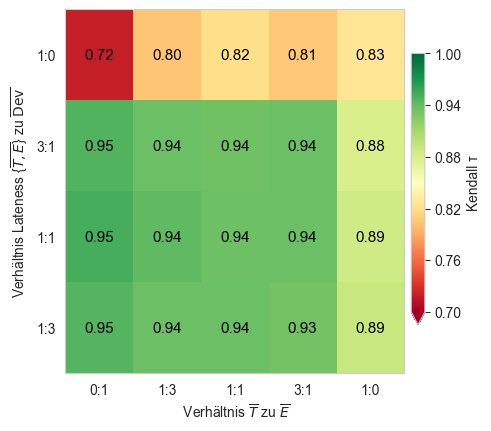

In [33]:
fig, axes = plot_experiment_heatmaps_kendall_tau(
    df_experiments,
    value_col="Mean_Kendall_Tau",
    x_col="Inner Tardiness Ratio", x_col_as=  r" Verhältnis $\overline{T}$ zu $\overline{E}$",
    y_col="Abs Lateness Ratio", y_col_as= r"Verhältnis Lateness {$\overline{T,E}$} zu $\overline{\mathrm{Dev}}$",
    vmin=0.7,
    extend="auto",
    fontsize=11
)

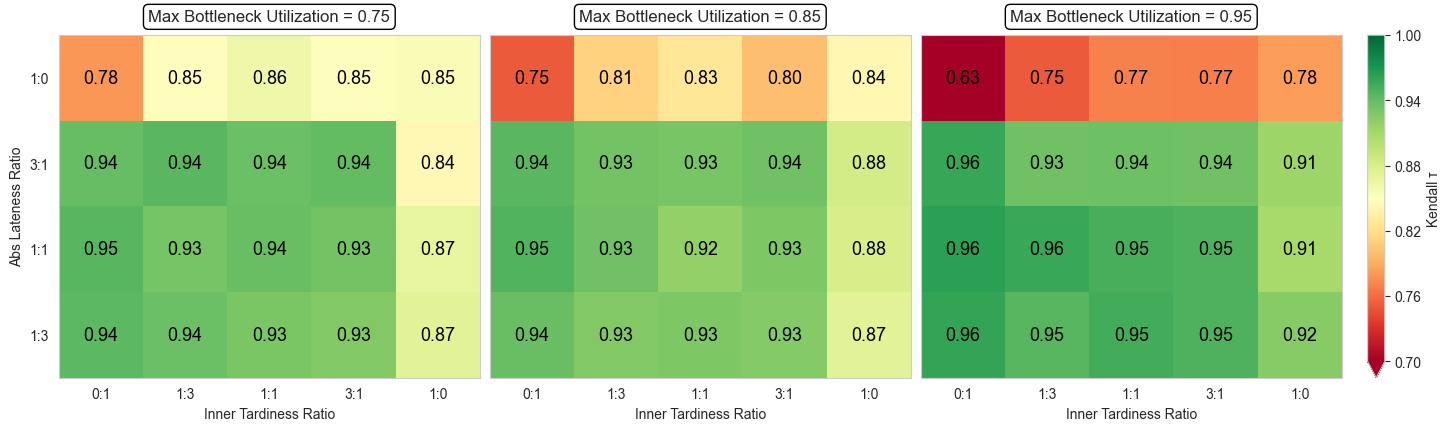

In [34]:
# 1) Kendall Tau (hoch = gut)
fig, axes = plot_experiment_heatmaps_kendall_tau(
    df_experiments,
    value_col="Mean_Kendall_Tau",
    x_col="Inner Tardiness Ratio",
    y_col="Abs Lateness Ratio",
    col_col="Max Bottleneck Utilization",
    vmin=0.7, fmt=".2f",
    extend="auto"  # oder "both" | "min" | "max" | None
)


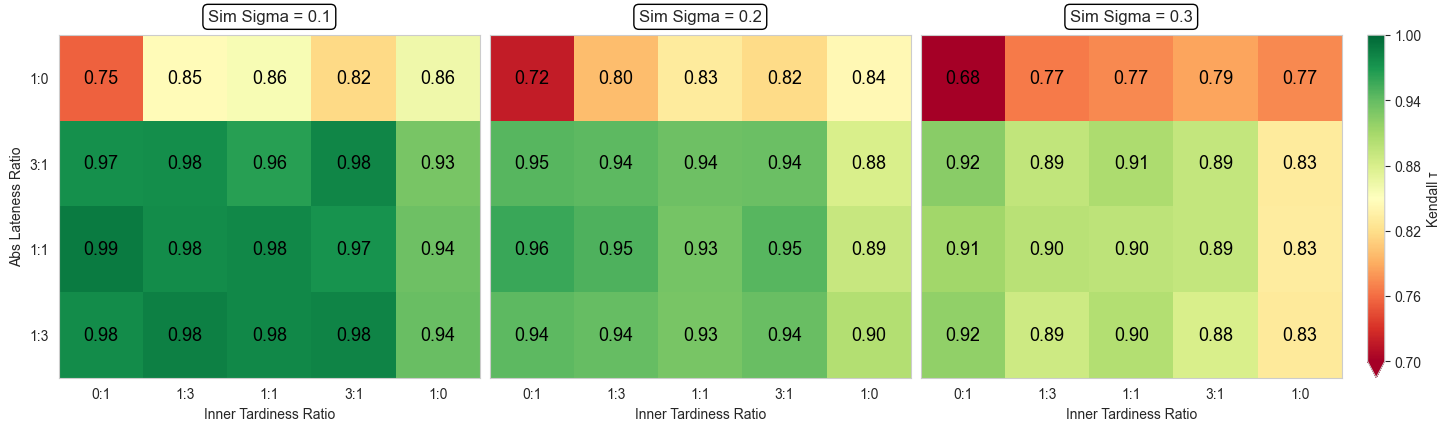

In [35]:
# 1) Kendall Tau (hoch = gut)
fig, axes = plot_experiment_heatmaps_kendall_tau(
    df_experiments,
    value_col="Mean_Kendall_Tau",
    x_col="Inner Tardiness Ratio",
    y_col="Abs Lateness Ratio",
    col_col="Sim Sigma",
    vmin=0.7, fmt=".2f",
    extend="auto"  # oder "both" | "min" | "max" | None
)

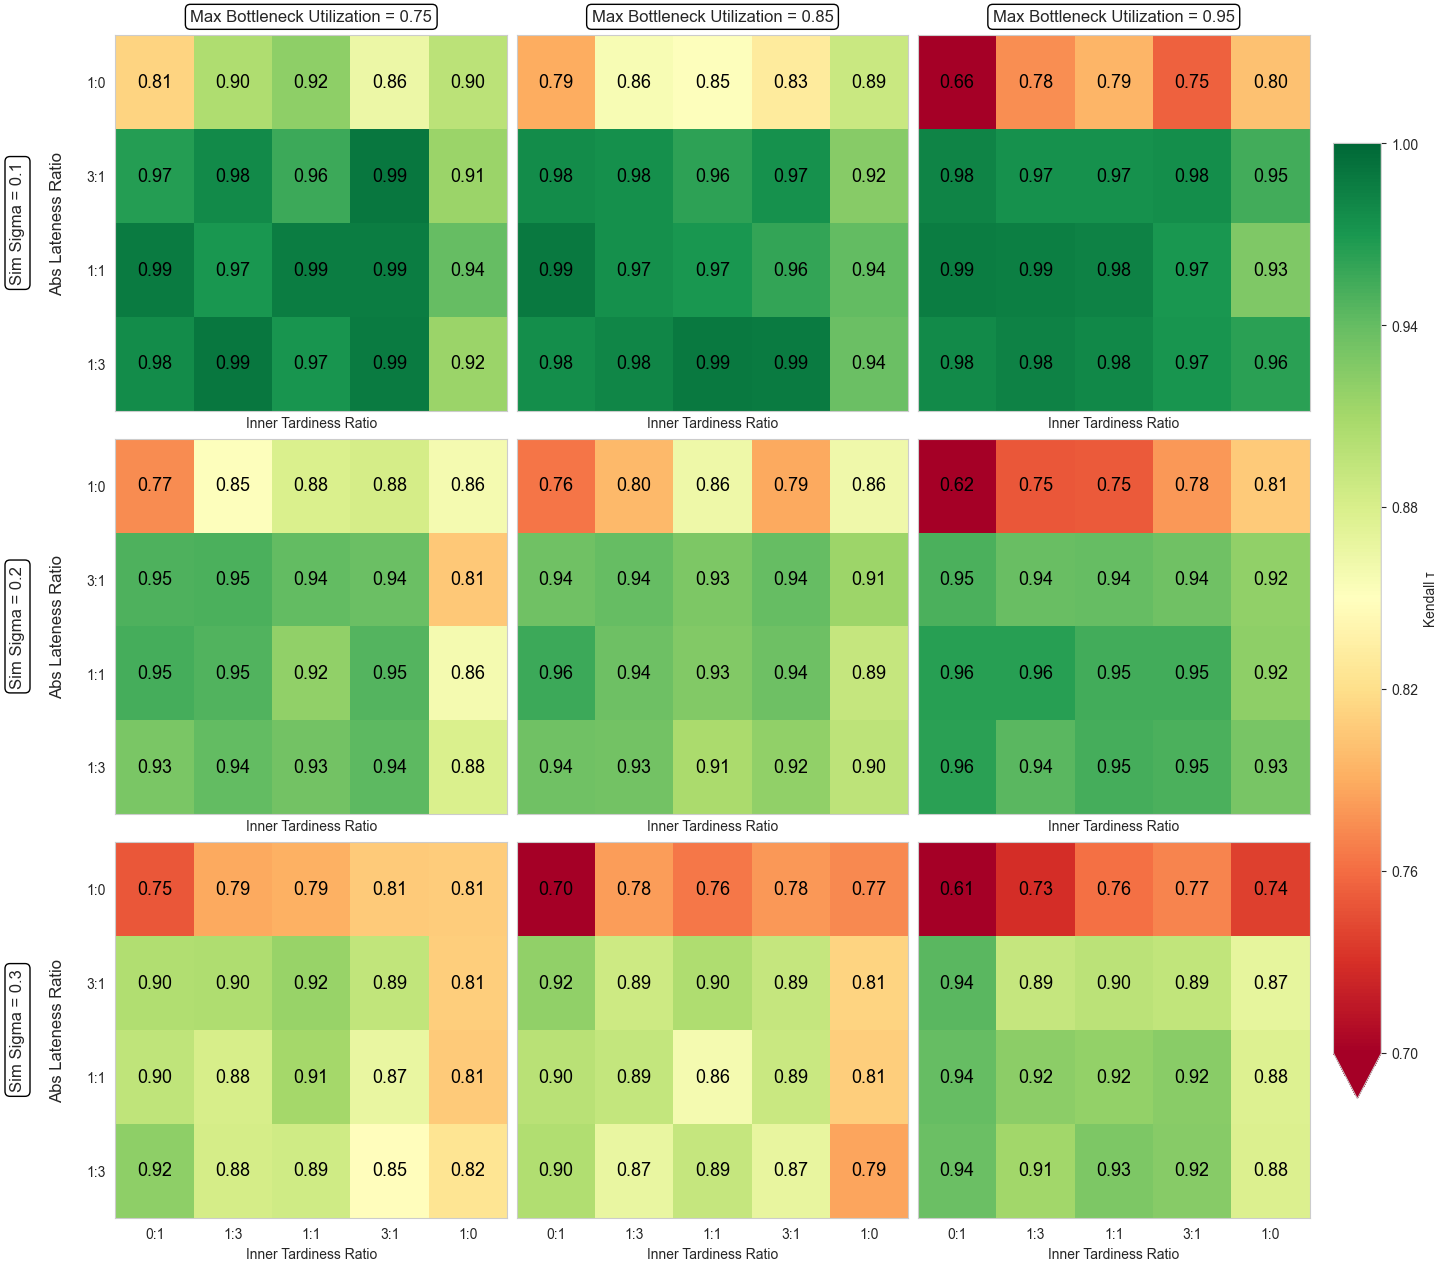

In [11]:
# 1) Kendall Tau (hoch = gut)
fig, axes = plot_experiment_heatmaps_kendall_tau(
    df_experiments,
    value_col="Mean_Kendall_Tau",
    x_col="Inner Tardiness Ratio",
    y_col="Abs Lateness Ratio",
    col_col="Max Bottleneck Utilization",
    row_col="Sim Sigma",
    vmin=0.7, fmt=".2f",
    extend="auto"  # oder "both" | "min" | "max" | None
)

fig.savefig("Heatmap_Mean_Kendall_Tau.png", dpi=300)

### II. Tardiness

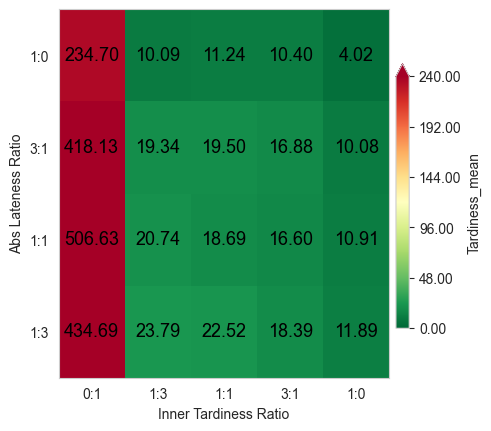

In [37]:
fig.savefig("Heatmap_Mean_Kendall_Tau.png", dpi=300)
# 2) Tardiness (niedrig = gut)
fig, axes = plot_experiment_heatmaps_good_low(
    df_experiments,
    value_col="Tardiness_mean",
    x_col="Inner Tardiness Ratio",
    y_col="Abs Lateness Ratio",
    vmin=0.0, vmax=240,
    #vmax=df_experiments["Mean_Tardiness"].max(),
    annot=True, fmt=".2f",
    extend="auto"
)

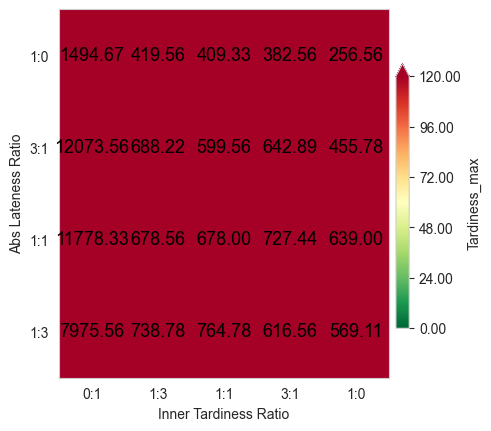

In [38]:
fig.savefig("Heatmap_Mean_Kendall_Tau.png", dpi=300)
# 2) Tardiness (niedrig = gut)
fig, axes = plot_experiment_heatmaps_good_low(
    df_experiments,
    value_col="Tardiness_max",
    x_col="Inner Tardiness Ratio",
    y_col="Abs Lateness Ratio",
    vmin=0.0, vmax=120,
    #vmax=df_experiments["Mean_Tardiness"].max(),
    annot=True, fmt=".2f",
    extend="auto"
)

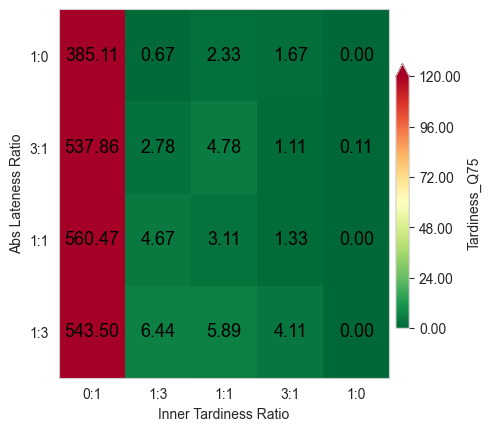

In [41]:
fig.savefig("Heatmap_Mean_Kendall_Tau.png", dpi=300)
# 2) Tardiness (niedrig = gut)
fig, axes = plot_experiment_heatmaps_good_low(
    df_experiments,
    value_col="Tardiness_Q75",
    x_col="Inner Tardiness Ratio",
    y_col="Abs Lateness Ratio",
    vmin=0.0, vmax=120,
    #vmax=df_experiments["Mean_Tardiness"].max(),
    annot=True, fmt=".2f",
    extend="auto"
)

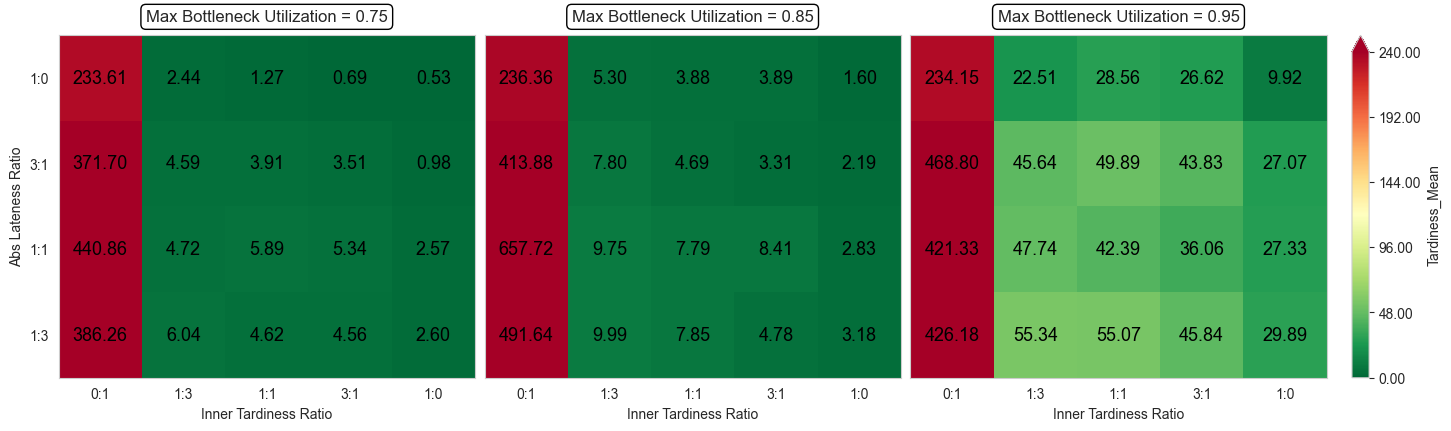

In [13]:
### II. Tardiness
fig.savefig("Heatmap_Mean_Kendall_Tau.png", dpi=300)
# 2) Tardiness (niedrig = gut)
fig, axes = plot_experiment_heatmaps_good_low(
    df_experiments,
    value_col="Tardiness_Mean",
    x_col="Inner Tardiness Ratio",
    y_col="Abs Lateness Ratio",
    col_col="Max Bottleneck Utilization",
    vmin=0.0, vmax=240,
    #vmax=df_experiments["Mean_Tardiness"].max(),
    annot=True, fmt=".2f",
    extend="auto"
)

#fig.savefig("Heatmap_Tardiness.png", dpi=300)

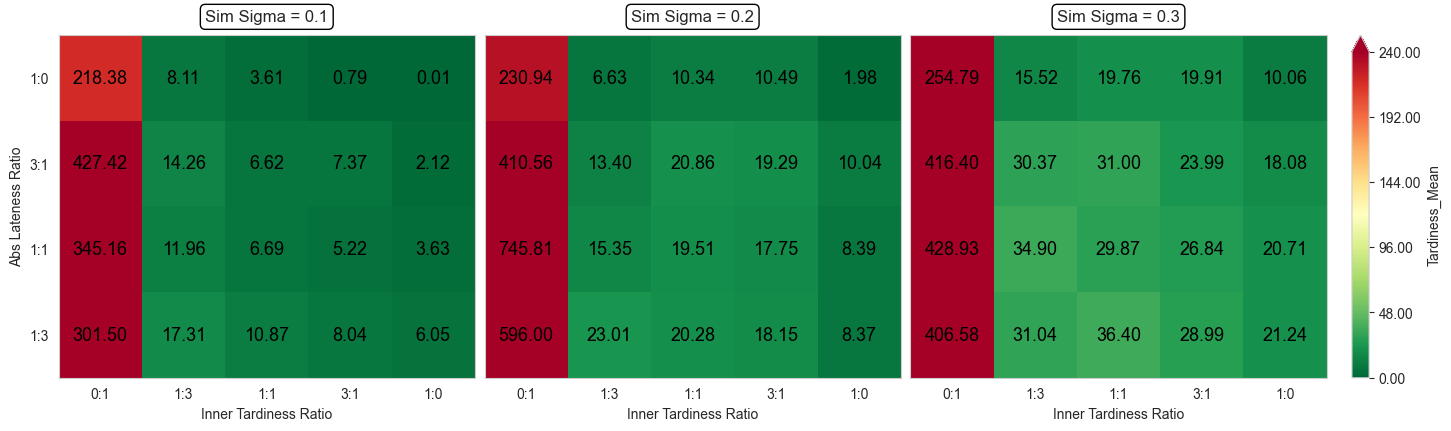

In [14]:
### II. Tardiness
fig.savefig("Heatmap_Mean_Kendall_Tau.png", dpi=300)
# 2) Tardiness (niedrig = gut)
fig, axes = plot_experiment_heatmaps_good_low(
    df_experiments,
    value_col="Tardiness_Mean",
    x_col="Inner Tardiness Ratio",
    y_col="Abs Lateness Ratio",
    col_col="Sim Sigma",
    vmin=0.0, vmax=240,
    #vmax=df_experiments["Mean_Tardiness"].max(),
    annot=True, fmt=".2f",
    extend="auto"
)

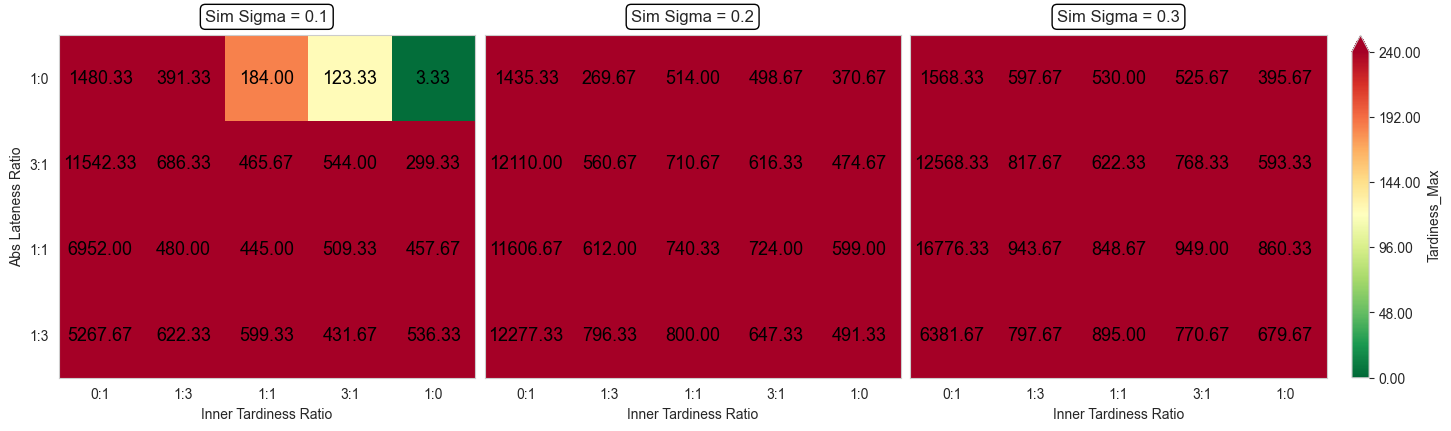

In [15]:
fig.savefig("Heatmap_Mean_Kendall_Tau.png", dpi=300)
# 2) Tardiness (niedrig = gut)
fig, axes = plot_experiment_heatmaps_good_low(
    df_experiments,
    value_col="Tardiness_Max",
    x_col="Inner Tardiness Ratio",
    y_col="Abs Lateness Ratio",
    col_col="Sim Sigma",
    vmin=0.0, vmax=240,
    #vmax=df_experiments["Mean_Tardiness"].max(),
    annot=True, fmt=".2f",
    extend="auto"
)

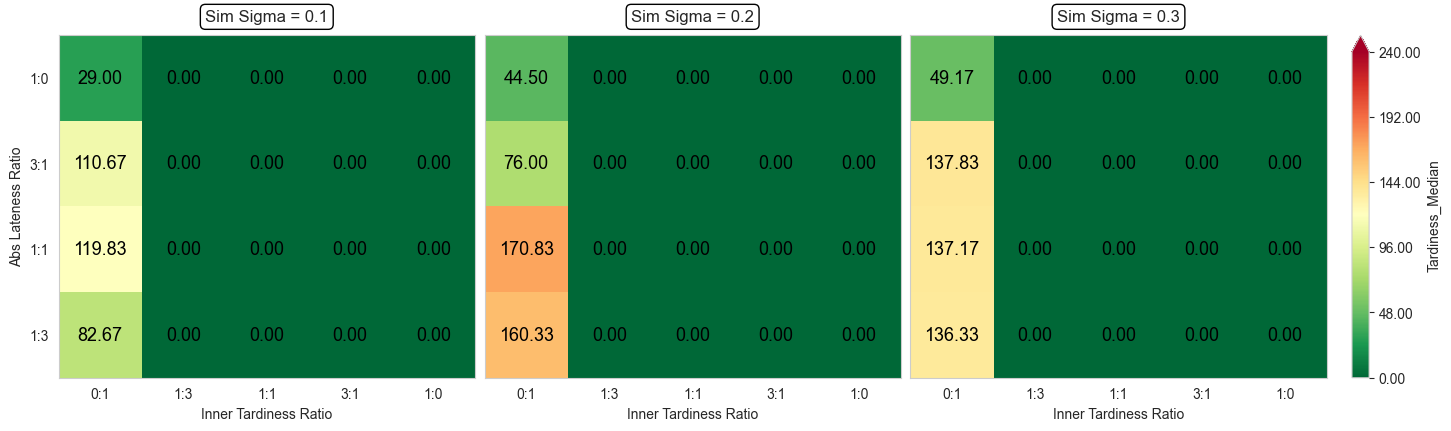

In [19]:
fig.savefig("Heatmap_Mean_Kendall_Tau.png", dpi=300)
# 2) Tardiness (niedrig = gut)
fig, axes = plot_experiment_heatmaps_good_low(
    df_experiments,
    value_col="Tardiness_Median",
    x_col="Inner Tardiness Ratio",
    y_col="Abs Lateness Ratio",
    col_col="Sim Sigma",
    vmin=0.0, vmax=240,
    #vmax=df_experiments["Mean_Tardiness"].max(),
    annot=True, fmt=".2f",
    extend="auto"
)

### III. Earliness

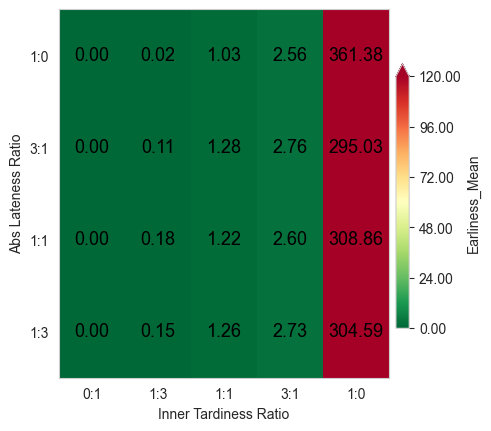

In [16]:
# 2) Earliness (niedrig = gut)
fig, axes = plot_experiment_heatmaps_good_low(
    df_experiments,
    value_col="Earliness_Mean",
    x_col="Inner Tardiness Ratio",
    y_col="Abs Lateness Ratio",
    vmin=0.0, vmax= 120,
    #vmax=df_experiments["Mean_Tardiness"].max(),
    annot=True, fmt=".2f",
    extend="auto"
)

fig.savefig("Heatmap_Earliness.png", dpi=300)

### IV. Devition

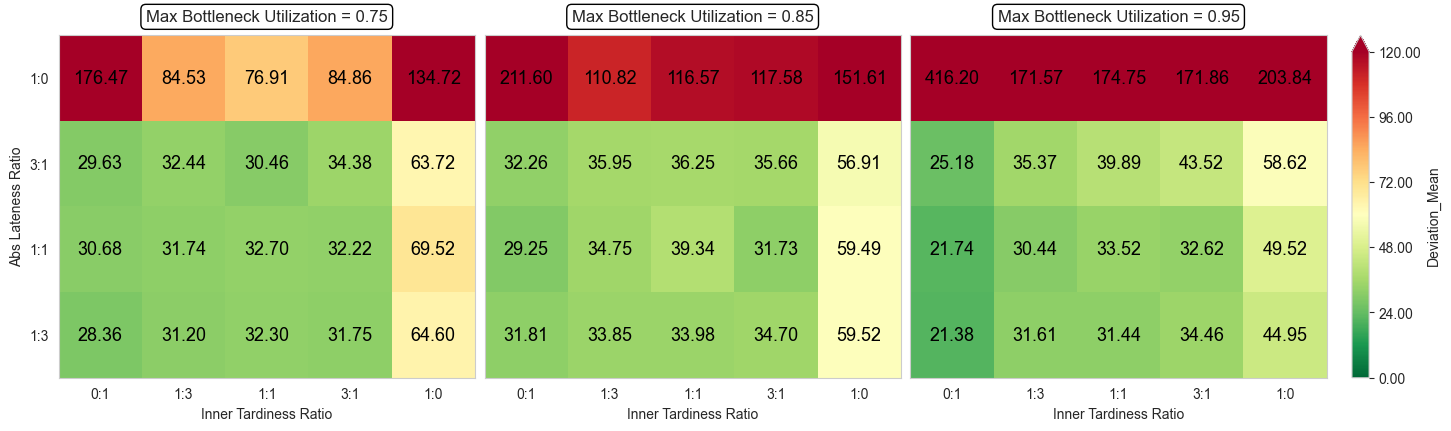

In [17]:
# 3) Deviation (niedrig = gut)
fig, axes = plot_experiment_heatmaps_good_low(
    df_experiments,
    value_col="Deviation_Mean",
    x_col="Inner Tardiness Ratio",
    y_col="Abs Lateness Ratio",
    col_col="Max Bottleneck Utilization",
    vmin=0.0, vmax= 120,
    #vmax=df_experiments["Mean_Tardiness"].max(),
    annot=True, fmt=".2f",
    extend="auto"
)

fig.savefig("Heatmap_Deviation.png", dpi=300)

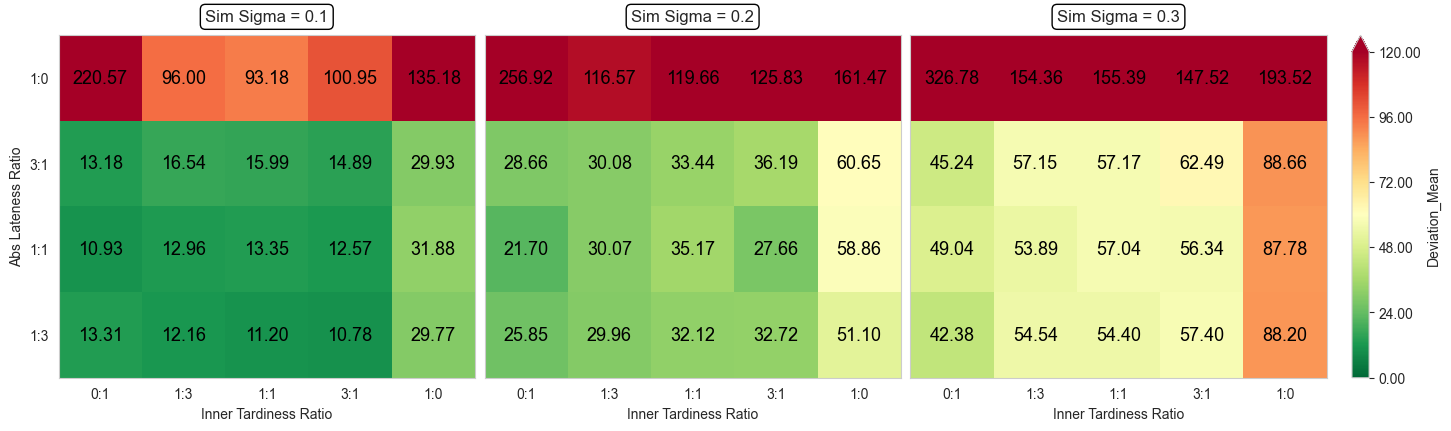

In [18]:
# 3) Deviation (niedrig = gut)
fig, axes = plot_experiment_heatmaps_good_low(
    df_experiments,
    value_col="Deviation_Mean",
    x_col="Inner Tardiness Ratio",
    y_col="Abs Lateness Ratio",
    col_col="Sim Sigma",
    vmin=0.0, vmax= 120,
    #vmax=df_experiments["Mean_Tardiness"].max(),
    annot=True, fmt=".2f",
    extend="auto"
)

fig.savefig("Heatmap_Deviation.png", dpi=300)